c:\Users\adefa\miniconda3\envs\ocr-javanese\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 43442 (\N{JAVANESE LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adefa\miniconda3\envs\ocr-javanese\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 43428 (\N{JAVANESE LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


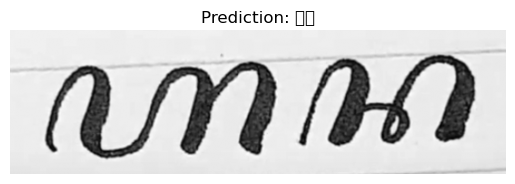

Hasil Prediksi: ꦲꦤ


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
from PIL import Image
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt

NGLEGENA = [
    ("ꦲ","ha"), ("ꦤ","na"), ("ꦕ","ca"), ("ꦫ","ra"), ("ꦏ","ka"),
    ("ꦢ","da"), ("ꦠ","ta"), ("ꦱ","sa"), ("ꦮ","wa"), ("ꦭ","la"),
    ("ꦥ","pa"), ("ꦝ","dha"), ("ꦗ","ja"), ("ꦪ","ya"), ("ꦚ","nya"),
    ("ꦩ","ma"), ("ꦒ","ga"), ("ꦧ","ba"), ("ꦛ","tha"), ("ꦔ","nga"),
]

num_classes = 21
char_list = [c[0] for c in NGLEGENA]
char2idx = {c: i+1 for i, c in enumerate(char_list)}
idx2char = {i+1: c for i, c in enumerate(char_list)}
NUM_CLASSES = len(char_list) + 1


class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.MaxPool2d((2, 1)),
            nn.AdaptiveAvgPool2d((1, None))
        )

        # FIX: Define multi-layer LSTM here instead of Sequential
        self.rnn = nn.LSTM(
            input_size=512, 
            hidden_size=256, 
            num_layers=2, 
            bidirectional=True, 
            batch_first=True
        )

        # Bidirectional LSTM output size is hidden_size * 2
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # x shape: [batch, 1, 32, 128]
        x = self.cnn(x) 
        
        # After CNN & Adaptive Pool: [batch, 512, 1, width_reduced]
        x = x.squeeze(2)          # [batch, 512, width_reduced]
        x = x.permute(0, 2, 1)    # [batch, width_reduced, 512]
        
        # FIX: LSTM returns (output, hidden_state), we only need output
        x, _ = self.rnn(x)        # [batch, width_reduced, 512]
        
        x = self.fc(x)            # [batch, width_reduced, num_classes]
        return x



def predict_javanese(img_path, model_path, idx2char):
    # 1. Konfigurasi Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # 2. Inisialisasi Model & Load Weight
    # Pastikan NUM_CLASSES sesuai dengan saat training 
    model = CRNN(num_classes).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
    model.eval()

    # 3. Preprocessing Gambar (Harus sama dengan training)
    transform = T.Compose([
        T.Grayscale(1),
        T.Resize((32, 128)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load dan transform gambar
    image = Image.open(img_path).convert("L")
    image_tensor = transform(image).unsqueeze(0).to(device) # Tambah dimensi batch

    # 4. Forward Pass
    with torch.no_grad():
        logits = model(image_tensor)
        
    # 5. CTC Decode (Greedy Search)
    preds = logits.argmax(2) # [batch, seq_len]
    pred = preds[0]
    
    decoded_text = []
    prev = 0
    for p in pred:
        p = p.item()
        if p != prev and p != 0: # 0 adalah index untuk blank token
            decoded_text.append(idx2char[p])
        prev = p
    
    result = "".join(decoded_text)

    # 6. Visualisasi
    plt.imshow(image, cmap='gray')
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    return result

prediction = predict_javanese("image.png", "best_crnn_nglegena.pt", idx2char)
print(f"Hasil Prediksi: {prediction}")